# Libraries

In [1]:
import numpy as np ###v1.20.3
import astropy###v4.3.1
from astropy.io import fits
import matplotlib.pyplot as plt###v3.4.3
import cv2 #!pip3 install opencv-python ###v4.5.5
from scipy import signal ### v1.7.1
from scipy.signal import find_peaks
from astropy.io import fits
from PIL import Image###v8.4.0
from skimage import io, color###V0.18.3
import math
from tkinter import *

# Functions

In [2]:
def fits2png(filename):
    
    """
    The function open fits file and return PIL Image file for visualisation
    and array with initial data from fits file
    """ 
    data_fits = fits.open(f"{filename}")[0].data
    plt.imsave(f"{filename}.jpg",data_fits[::-1])

    return data_fits

def subimage_preob(data, x1,y1,x2,y2,x3,y3,x4,y4): #calib, center, theta, width, height):
    ''' 
    Rotates OpenCV image around center with angle theta (in deg)
    then crops the image according to width and height.
    '''
    tan = (y2-y1)/(x2-x1)
    radian = math.atan2((y1-y2),(x1-x2))
    theta = radian*180/np.pi
    if theta > 90:
        theta = -180 + theta
    elif theta < -90:
        theta = 180 + theta
    else:
        theta = theta
    print(theta)
    
    polygon_data = ((x1,y1), (x2, y2), (x3, y3), (x4, y4)) 
    center = centroid(polygon_data) #обращается к фукции centroid
    
    shape = (data.shape[1],data.shape[0])
    #center = (int(shape[0]/2),int(shape[1]/2))
    matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 ) #поворот матрицы вокруг указанного центра
    data_rotated = cv2.warpAffine(src=data, M=matrix, dsize=shape ) #сохранение повернутого изображения из матриц
    
    width = ((x1-x2)**2+(y1-y2)**2)**0.5
    height = ((x1-x4)**2+(y1-y4)**2)**0.5
    
    
    x = int( center[0] - width/2  ) #поиск координаты x слева
    y = int( center[1] - height/2 ) # поиск координаты у снизу

    data_croped = data_rotated[ y:int(y+height), x:int(x+width) ] #обрезка изображения по координатам
    
    #preob
    array_log10 = np.log10(65536/data_croped)*1000 #(257.003921569 = 65536/255), also data (смещение запятой)
    mean = array_log10.mean(axis=0) #среднее значение по столбцам
    
    
    plt.imshow(data_croped) #path -- путь к корневой дирректории
    #plt.gca().invert_yaxis()
    #возвращает обрезанное изображение
    return data_croped

def centroid(vertexes):
    x_list = [vertex[0] for vertex in vertexes]
    y_list = [vertex[1] for vertex in vertexes]
    lenth = len(vertexes)
    x = sum(x_list) / lenth
    y = sum(y_list) / lenth
    return(x, y)


def peaks(mean,order):
    """
    function for searching peaks in array 
    """
    peak_indexes = signal.argrelextrema(mean, np.greater, order=order)[0] #индексы пиков 
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in peak_indexes:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа
    return peak_indexes,peak_mean

def peaks_our(mean):    
    
    for ind,p in enumerate(mean): 
        
        if p < mean[ind+1]:
            continue
        
        else:
            first_peak_ind = ind
            break

    random_peak_ind=[first_peak_ind]
    
    for ind in range(first_peak_ind+1,len(mean)-1):
        
        if mean[ind] > mean[ind-1] and mean[ind] > mean[ind+1]:
            random_peak_ind.append(ind)
            
    bad_peaks = []
    good_peaks = []
    min_dist = 10
    counter = 0
    
    for ind in range(0,len(random_peak_ind)-1):
        delta = random_peak_ind[ind+1] - random_peak_ind[ind]
        
        if delta < min_dist:
            bad_peaks.append(random_peak_ind[ind])
            bad_peaks.append(random_peak_ind[ind+1])
        
        else:
            
            if len(bad_peaks)==0:
                good_peaks.append(random_peak_ind[ind])
            
            else:
                bad_peaks = np.array(np.unique(bad_peaks))
                mean_index = int(bad_peaks.mean())
                good_peaks.append(mean_index)
                bad_peaks = []

    good_peaks.append(random_peak_ind[-1])
    
    if len(good_peaks) > 9:
        
        if mean[[good_peaks[-1]]] < mean[[good_peaks[-2]]]:
            good_peaks = good_peaks[:-1] 
            
    peak_mean =[] # создаем пустой массив для средних значений пиков
    for i in range(0,len(mean)):
        if i in good_peaks:
            peak_mean.append((mean[i-2]+mean[i-1]+mean[i]+mean[i+1]+mean[i+2])/5) # ищем среднее по пяти рядом стоящих значений
    #возвращает позицию/индекс найденного пика и среднее значение по пяти значениям : пик + 2 слева + 2 справа        

    return good_peaks, peak_mean                    


def aprx1(x,y,order):
    
    """
    DOUBLE APPROXIMATION
    """

    monotone = False
    while monotone == False:
        
        z = np.polyfit( x,y,order)
        p = np.poly1d(z)
        xp = np.linspace(0, x[-1], 1000)
        # print(xp)
        pxp = p(xp)

        for i in range(1,len(pxp)):
            max_pxp = y[:-1].max()
            if pxp[i]<=pxp[i-1]:
                pxp[i]=pxp[i-1]+1
                if pxp[i]>=max_pxp:
                    min_pxp = pxp[i-100]
                    delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                    index = i-10
                    break


        for j in range(index+1,len(pxp)):
            pxp[j]=pxp[j-1]+delta_pxp

        z = np.polyfit( xp,pxp, 6)
        pp = np.poly1d(z)
        xpp = np.linspace(0, x[-1], 1000)

        pxpp = pp(xpp)
        
        check = []
        for k in range(0,len(pxpp)-1):      
            if pxpp[k]>pxpp[k+1]:
                check.append(k)
        
        if len(check) == 0:
                monotone = True
        else:
            order = order+1
            monotone = False
               
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=80)
    ax1 = plt.scatter(x[:-1],y[:-1], color="blue",s=5) 
    ax1 = plt.plot(xp, p(xp), color="orange")           

    fig, ax2 = plt.subplots(figsize=(6,4),dpi=120)
    ax2 = plt.plot( xpp, pp(xpp), lw=1, label = f"Апроксимация полиномом ({order},6)")#"Polynomial approximation")
    ax2 = plt.scatter(x[:-1],y[:-1], color="red",s=50,marker='.')#, label = "Attenuator magnitude")
    plt.legend()
    plt.xlabel("Интенсивность")
    plt.ylabel("Почернение")
#     plt.yticks([200, 300, 400, 500, 600, 700, 800, 900])
    plt.savefig("characteristic_curve.jpg")
    return xpp,pp

def aprx2(x,y,order):

    """
    MONO APPROXIMATION
    """
        
    z = np.polyfit( x,y,order)
    p = np.poly1d(z)
    xp = np.linspace(x[0], x[-1], 1000)
    # print(xp)
    pxp = p(xp)

    for i in range(1,len(pxp)):
        max_pxp = y[:-1].max()
        if pxp[i]<=pxp[i-1]:
            pxp[i]=pxp[i-1]+1
            if pxp[i]>=max_pxp:
                min_pxp = pxp[i-100]
                delta_pxp = abs((max_pxp - min_pxp)/(len(pxp)-i-1))
                index = i-10
                break


    for j in range(index+1,len(pxp)):
        pxp[j]=pxp[j-1]+delta_pxp
               
    fig, ax1 = plt.subplots(figsize=(6,4),dpi=120)
    ax1 = plt.scatter(x,y, color="blue",s=50) 
    ax1 = plt.plot(xp, p(xp), color="orange",lw=2,label=f"Полином ({order})")   
    plt.legend()
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd_polinomial.jpg")
    
    return xp,p

def mean_deviation(x_array,y_array):

    c = []
    for i in range(1,len(y_array)):
        c.append(abs(y_array[i] - y_array[i-1]))
    mean_deviation = np.array(c).sum()/len(y_array)

    #now we sort our data: if delta between neighboring elements larger than 2 mean deveation we will remove it
    indexes = []
    for i in range(1,len(y_array)):
        if abs(y_array[i]-y_array[i-1])>mean_deviation*2:
            indexes.append(i)

    y_array = np.delete(y_array,indexes)
    x_array = np.delete(x_array,indexes)
    xarray_flux = 10000/10**(x_array/2.5)
    a = []
    for i in range(0,len(xarray_flux)):
        a.append([xarray_flux[i],y_array[i]])

    a.sort(key=lambda x:x[0])

    xarray_flux = []
    y_array = []

    for i in range(0,len(a)):
        xarray_flux.append(a[i][0])
        y_array.append(a[i][1])

    xarray_flux = np.array(xarray_flux)
    y_array = np.array(y_array)       
    del a
    
    plt.figure(figsize=(6,4),dpi=120)
    plt.plot(xarray_flux, y_array, markersize=3,marker='o' )
    plt.xlabel("Интенсивность")
    plt.ylabel("Почернение")
#     plt.savefig("characteristic_curve_first.jpg")
    
    return xarray_flux, y_array

def rounding(value):
    """
    Rounds values taking into accaunt fraction part
    
    value -- float number 
    
    Example:
    3.1 -> 3
    3.6 -> 4
    """
    try:
        value = float(value)
    except ValueError:
        print("Input should be a digit or a float!")
    
    if value > 0:
        sign = 1
    else:
        sign = -1
        
    value = abs(value)
    
    frac = value - int(value)
    
    if frac >= 0.5:
        return math.ceil(value)*sign
    else:
        return math.floor(value)*sign
        

def moving_average(n_points, array):
    """
    RETURNS "BLURED" ARRAY
    
    n_points -- number of points for moving average
    array - usually y array
    """
    # выберем кол-во точек для скользящего среднего
    n_points = 10
    
    # создаем функцию окна
    W = np.zeros_like(array); W[0:n_points]=1
    
    FConv = np.fft.fft(array)*np.fft.fft(W)
    
    TConv = np.fft.ifft(FConv).real/n_points
    
    # отбрасываем те точки, где скользящее среднее неадекватно срабатывает 
    # то есть первые и последние N_rm/2 точек
    
    Nskip = int((n_points-1)/2) 
    return np.pad(TConv[Nskip:],(0,Nskip),'constant')


def polynomial_alighn(data,low_limit,up_limit,order):
    
    """
    function aligns the spectrum through finding min value in each column and approximate it with polynomial and mean for polinomial line
    
    data - whole image
    up_limit,low_limit - limits of spectra in rows number
    order - polinomial order to approximate spectra
    
    """
    
    data_part = data[low_limit:up_limit]
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
    ax1.imshow(data_part, cmap='gray')
#     plt.imsave('pic_lamp_20s.jpg', data_part)
    ax1.set_title("Initial part of spectra")
#     plt.savefig("initial_part.eps")
    
    #create massive of part of whole spectra with arrays of columns, not rows
    data_columns = []
    for i in range(0,len(data_part[0])):
        data_columns.append(list(data_part[:,i]))
    data_columns=list(data_columns)
    
    #create massive of whole spectra with arrays of columns, not rows
    data_collumns_entire_image = []
    for j in range(0,len(data[0])):
        data_collumns_entire_image.append(list(data[:,j]))
    data_collumns_entire_image=list(data_collumns_entire_image)

    #find min value in each column and then find indexes of the values - they will be Y-coordinate
    data_col_min = []#data_part.min(axis=0)
    for i in range(0,len(data_columns)):
        #print("HELLO")
        #print(np.median(data_columns[i]))
        data_col_min.append(np.median(data_columns[i]))
        
    index = []
    for i in range(0,len(data_col_min)):
            index.append(data_columns[i].index(data_col_min[i]))


    #find median value of neighboring indexes of min values in each column in some ranges to compairing in the next steps
    #we schould find mediam values for ranges not for whole image, because we have non-linear graph and it has curvature  
    median = []
    n = 0
    while n+100<len(index):
        k=n+100
        median.append([n,k,np.median(index[n:k])])
        n=k
    else:
        median.append([n,-1,np.median(index[n:])])

    #calculate mean delta between neighboring values
    delt=[]
    for i in range(1,len(index)):
        delt.append(abs(index[i]-index[i-1]))
    delt_mean = np.array(delt).sum()/len(delt)    

    #now we compair difference between median value indexes of minimum value in each column     
    for i in median:
        for j in range(i[0],i[1]):
            if abs(i[2]-index[j])>delt_mean:
                index[j] = i[2]

    fig, ax2 = plt.subplots(figsize=(8,5),dpi=100)
    ax2.plot(index)
    
    #plot polynomial
    xp = np.arange(0,len(index))
    z = np.polyfit(xp,index, order)
    polynomial = np.poly1d(z)
    y_polynomial = polynomial(xp)
    ax2.plot(index, color="steelblue", label="Srectra line") 
    ax2.plot(xp, y_polynomial, color="orange", label=f"Polinomial, order = {order}")
    ax2.set_title("Polinomial approximation of spectra")
    ax2.legend()
#     plt.savefig("polinomial_spectra.eps")
    
    xp_tg = np.arange(0,len(y_polynomial))
    z_tg = np.polyfit(xp_tg,y_polynomial, 1)
    polynomial_tg = np.poly1d(z_tg)
    y_polynomial_tg = polynomial_tg(xp_tg)
    tg = polynomial_tg[1]
    
    #now we will plot our curve on our frame
    mean_polynomial = y_polynomial.mean()
    fig, ax3 = plt.subplots(figsize=(8,5),dpi=100)
    ax3.imshow(data_part, cmap='gray')
    ax3.plot(xp, y_polynomial, color="orange", label=f"Polinomial, order = {order}")
    ax3.axhline(mean_polynomial, label="Polinomial mean")
#     ax3.legend(bbox_to_anchor=(1.01,0.5))
#     plt.savefig("polinomial_mean.eps")
    
    delta_y = []
    for i in range(0,len(index)):
        delta = mean_polynomial - polynomial(xp)[i]
        delta_y.append(rounding(delta))

    shape = np.array(data_collumns_entire_image).shape
    new_pic_col = np.zeros(shape)
    for i in range(0,len(data_collumns_entire_image)):
        for j in range(0,len(data_collumns_entire_image[i])):
            m  = j + delta_y[i]
            if m<len(data_collumns_entire_image[i]):
                new_pic_col[i][m] = data_collumns_entire_image[i][j] 
            else:
                m = m - len(data_collumns_entire_image[i])
                new_pic_col[i][m] = data_collumns_entire_image[i][j] 
    data_rows = []
    for i in range(0,len(new_pic_col[0])):
        data_rows.append(list(new_pic_col[:,i]))
            
    
    delta_x = np.arange(0,len(data_rows))*tg
    shape = np.array(data_rows).shape
    new_data_rows = np.zeros(shape)
    for i in range(0,len(data_rows)):
        for j in range(0,len(data_rows[i])):
            m  = rounding(j + 2*delta_x[i])
            if m<len(data_rows[i]):
                new_data_rows[i][m] = data_rows[i][j] 
            else:
                m = m - len(data_rows[i])
                new_data_rows[i][m] = data_rows[i][j] 
    
    aligned_image = new_data_rows
    
    fig, ax4 = plt.subplots(figsize=(8,5),dpi=100)
    ax4.imshow(aligned_image, cmap='gray')
    ax4.grid()
    ax4.set_title("Aligned spectra 1st")
    #_________________________________________________________________________
    
    plt.savefig("aligned_spectra.eps")
    plt.savefig("aligned_spectra.jpg")
    
    
    return aligned_image

def preob_spectra(spectra):
    
    """
    Функция пересчитывает плотности почернения в интенсивности при помощи полинома, полученного 
    в работе с калибровками.
    На выходе преобразованный спектр и график, из которого необходимо определить на каких строках (х1 и х1) находится спектр.
    Тут же можно определить где находятся лампы.
    """
    x_log = (np.log10(65535/spectra) * 1000)
#     spectra_ = (2.803e-20*x_log**6 - 5.835e-16*x_log**5 + 1.635e-12*x_log**4 + 4.247e-08*x_log**3 - 0.0004067*x_log**2 + 1.439*x_log + 196.7).sum()
    
    spectra_ = polinomial(x_log)
#     
    sum_intens_row = spectra_.sum(axis=1)
    
    plt.figure(figsize=(6,4),dpi=120)
    plt.plot(sum_intens_row)
#     plt.grid(lw=0.1)
    plt.xlabel("Номер строки пикселей")
    plt.ylabel("Сумма интенсивностей")
#     plt.savefig("spectra_background_row1972s.jpeg")
    return spectra_

def spectra_lamps(data,y1,y2,y3,y4,y5,y6):
    
    """
    Функция для вырезания из целого изображения спектра двух ламп и
    спектра самого объекта по отдельнсти.
    """
    
    lamp_1 = data[y1:y2]
    spectra = data[y3:y4]
    lamp_2 = data[y5:y6]
    
    
    fig, ax1 = plt.subplots(figsize=(10,8),dpi=120)
    ax1.imshow(lamp_1)
    ax1.set_title("lamp1")
    
    
    fig, ax2 = plt.subplots(figsize=(10,8),dpi=120)
    ax2.imshow(spectra)
    ax2.set_title("spectra")

    fig, ax3 = plt.subplots(figsize=(10,8),dpi=120)
    ax3.imshow(lamp_2)
    ax3.set_title("lamp2")

    
    fig, ax4 = plt.subplots(figsize=(10,8),dpi=120)
    ax4.imshow(data)
    ax4.set_title("data")
    ax4.axhline(y1,c="r",lw=1)
    ax4.axhline(y2,c="r",lw=1)
    ax4.axhline(y3,c="b",lw=1)
    ax4.axhline(y4,c="b",lw=1)
    ax4.axhline(y5,c="r",lw=1)
    ax4.axhline(y6,c="r",lw=1)
    
    return lamp_1, spectra, lamp_2

def spectra_background(data,x1,x2):
    
    """
    Разбивает часть изображения со спектром на фон (над и под) и спектр.
    Вычитает фон из спектра и 
    на выходе выдает ГОТОВЫЙ спектр (+график, конечно же)
    """
    
    back_1 = data[0:x1]
    back_2 = data[x2:]
    back = np.concatenate((back_1,back_2))
    back_mean = back.mean(axis=0)
    
    spectrum = data[x1:x2]
    spectrum_sum = np.array(spectrum).sum(axis=0)
    spectrum_final = spectrum_sum - back_mean*(x2-x1)
    
    plt.figure(figsize=(8,4),dpi=120)
    plt.plot(spectrum_final)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
#     plt.savefig("spectra_obj_back.jpg")
    
    return spectrum_final

def standart_deviation(list_value):
    mean = np.mean(list_value)
    summ = []
    for i in list_value:
        summ.append((i-mean)**2)
    std = np.sqrt(np.sum(summ)/len(list_value))
    return std

def x_axis_to_wavelenght(lamp_1,lamp_2):
    
    lamp_1_std = standart_deviation(lamp_1)*0.5
    
    index_l_1 = []
    
    for i in range(1,len(lamp_1)-1):
        if lamp_1[i] > lamp_1_std and lamp_1[i] > lamp_1[i+1] and lamp_1[i] > lamp_1[i-1]:
            index_l_1.append(i)
     
    dalta_ind_l1 = []
    for i in range(1,len(index_l_1)):
        dalta_ind_l1.append(index_l_1[i]-index_l_1[i-1])
    delta_std_l1 = standart_deviation(dalta_ind_l1)
    
    index_l1 = []
    counter_l1 = 0 
    for i in range(0,len(index_l_1)):
            
            if counter_l1 == 0:
                index_l1.append(index_l_1[i])
                countr_l1 =+ 1
           
            else:
                d = index_l_1[i] - index_l_1[i-1]
                countr_l1 =+ 1
                if d < delta_std_l1:
                    index_l1.append(index_l_1[i])  
    
    
    index_l1_1 = index_l1[0]
    index_l1_2 = index_l1[-1]
    
    lamp_2_std = standart_deviation(lamp_2)
    
    index_l_2 = []
    for i in range(1,len(lamp_2)-1):
        if lamp_2[i] > lamp_2_std and lamp_2[i] > lamp_2[i+1] and lamp_2[i] > lamp_2[i-1]:
            index_l_2.append(i)
            
        
    dalta_ind_l2 = []
    for i in range(1,len(index_l_2)):
        dalta_ind_l2.append(index_l_2[i]-index_l_2[i-1])
    delta_std_l2 = standart_deviation(dalta_ind_l2)
    
    index_l2 = []
    counter_l2 = 0 
    for i in range(0,len(index_l_2)):
            
            if counter_l2 == 0:
                index_l2.append(index_l_2[i])
                countr_l2 =+ 1
           
            else:
                d = index_l_2[i] - index_l_2[i-1]
                countr_l2 =+ 1
                if d < delta_std_l2:
                    index_l2.append(index_l_2[i])          
            
            
    index_l2_1 = index_l2[0]
    index_l2_2 = index_l2[-2]
    
    index_1 = int(np.mean([index_l1_1,index_l2_1]))
    index_2 = int(np.mean([index_l1_2,index_l2_2]))
    

    #PLOT
    fig,(ax1,ax2) = plt.subplots(2,figsize=(8,4),dpi=120)
#     ax1.figure(figsize=(18,9))
    ax1.plot(lamp_1,label="Лампа 1")
    ax1.axhline(lamp_1_std,c="gray",lw=1)
    ax1.axvline(index_l1_1,c="r",lw=1)
    ax1.axvline(index_l1_2,c="r",lw=1)
    # ax1.scatter(index_l1_1, lamp_1[index_l1_1],c="r",s=83)
    # ax1.scatter(index_l1_2, lamp_1[index_l1_2],c="r",s=83)
    ax1.scatter(index_l1, lamp_1[index_l1],c="g")
#     ax1.set_title("Lamp 1")
    ax1.legend(loc=2)
    ax1.set_xlabel("Номер столбца пикселей")
    ax1.set_ylabel("Интенсивность")
    
    ax2.plot(lamp_2,label="Лампа 2")
    ax2.axhline(lamp_2_std,c="gray",lw=1)
    ax2.axvline(index_l2_1,c="r",lw=1)
    ax2.axvline(index_l2_2,c="r",lw=1)    
    # ax2.scatter(index_l2_1, lamp_2[index_l2_1],c="r",s=83)
    # ax2.scatter(index_l2_2, lamp_2[index_l2_2],c="r",s=83)    
    ax2.scatter(index_l2, lamp_2[index_l2],c="g")
#     ax2.set_title("Lamp 2")
    ax2.legend(loc=2)
    
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("Интенсивность")
    plt.savefig("wavelenght_lamp.jpg")
    
    return index_1,index_2, index_l1,index_l2

def pixel2wavelenght(spectra,lambd_0,lambd_n,N_0,N_n):
    
    """
    Function calculates mean dispersion of wavelenghts
    and convert numbers of columns to wavelenght using lamp spectra.
    
    spectra -- final spectra of object/lamp without background (1-d array)
    lambd_0 -- the wavelengths of the first line of lamp spectra in angstroms 
    lambd_n -- the wavelengths of the last line of lamp spectra in angstroms
    N_0 -- column number of the first line
    N_n -- column number of the last line
    """
    dispersion = (lambd_n - lambd_0)/(N_n - N_0)
    wavelenght = []
    
    for i in range(0,len(spectra)):
        delta = i - N_0
        wl = delta * dispersion #distance in angstrom between a column and first line column
        wavelenght.append(lambd_0+wl)
        
        #PLOT
    plt.figure(figsize=(18,9))
    plt.plot(wavelenght,spectra)
    
    return wavelenght,dispersion

def func(index_1,index_2,x1,x2,x3,x4,x5,lambd_1,lambd_2,lambd_3,lambd_4,lambd_5,wavelenght):
    
    delta_lambd_1 = wavelenght[x1] - lambd_1 
    delta_lambd_2 = wavelenght[x2] - lambd_2 
    delta_lambd_3 = wavelenght[x3] - lambd_3 
    delta_lambd_4 = wavelenght[x4] - lambd_4 
    delta_lambd_5 = wavelenght[x5] - lambd_5 
    
    print(wavelenght[x2])
    
    corr = np.array([0,delta_lambd_1,delta_lambd_2,delta_lambd_3,delta_lambd_4,delta_lambd_5,0]) #0 in the begging and in the end because we exactly know wavelenght of index_1,index_2
    
    plt.figure(figsize=(6,4), dpi=120)
    plt.scatter([index_1,x1,x2,x3,x4,x5,index_2],corr,s=50)
    plt.xlabel("Номер столбца пикселей")
    plt.ylabel("$\Delta \lambda$")
    plt.savefig("delta_lamd.jpg")
    xpp, polinomial = aprx2([index_1,x1,x2,x3,x4,x5,index_2],corr,3)
    
    columns = np.arange(0,len(wavelenght))
    
    correction_whole = np.array(polinomial(columns))
    
    wavelenght_corrected = wavelenght + correction_whole
    
    return wavelenght_corrected,polinomial

def graf(data, order):
    fig = plt.figure(figsize=(8,6),dpi = 100)
    ax1 = fig.add_subplot(2,1,1)
    x = np.arange(1, len(data) + 1)
    ax1.scatter(x,data,color = 'orangered', s = 2, alpha = 0.5)
    ax1.set_xlabel("Pixel")
    ax1.set_ylabel("Value of pixel")

    peak_indexes,peak_mean = peaks(data,order=order) #func_peaks
    ax2 = fig.add_subplot(2,1,2)
    x1 = np.arange(0,len(data))
    ax2.plot(x1,data)
    ax2.scatter(peak_indexes, data[[peak_indexes]], color = 'y', s = 10, marker = 'D', label = 'maxima')
    ax2.scatter(peak_indexes, peak_mean, color = 'r', s = 10, marker = 'D', label = 'maxima')
    ax2.set_xlabel("Pixel")
    ax2.set_ylabel("Value of pixel")
    
    return peak_indexes,peak_mean

In [3]:
mag_before_1972 = [0,0.61,1.1,1.47,1.84,2.25,2.66,3.04,0]
mag_after_1972 = [0,0.5,0.97,1.44,1.93,2.43,2.69,3.04,0]

# SPECTRA REDUCTION

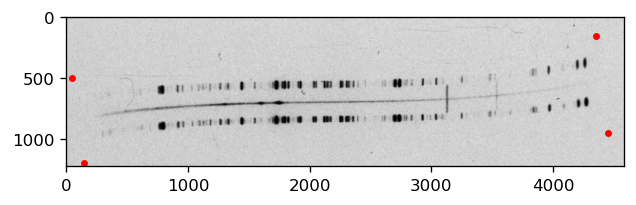

In [4]:
fits_NGC4151 = fits.open('NGC4151_16-6_1m_3200dpi.fit.fits')
data_NGC4151 = fits_NGC4151[0].data
plt.figure(figsize=(6,4),dpi=120)
plt.imshow(data_NGC4151, cmap='gray')
plt.scatter(150,1200,s=10,c="r")
plt.scatter(4450,950,s=10,c="r")
plt.scatter(4350,150,s=10,c="r")
plt.scatter(50,500,s=10,c="r")
# plt.axis("off")
#plt.imsave("data_MRK335_5.jpg",data_MRK335_5)

-3.2892426784918314


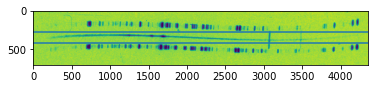

In [5]:
shape1 = data_NGC4151.shape[1]
shape0 = data_NGC4151.shape[0]

x1= 100
y1= 1200
x2= 4450
y2= 950

x3= 4350
y3= 150
x4= 50
y4= 500

image_data_NGC4151 = subimage_preob(data_NGC4151,x1,y1,x2,y2,x3,y3,x4,y4)
plt.axhline(270)
plt.axhline(420)

In [6]:
image_NGC4151 = np.array(image_data_NGC4151, dtype = 'uint16')
hdu = fits.PrimaryHDU(image_NGC4151)
hdulist = fits.HDUList([hdu])
hdulist[0].header = fits_NGC4151[0].header
hdulist.writeto('ngc4151_rotated.fits',overwrite=True)

ValueError: 26057.0 is not in list

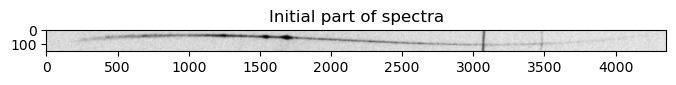

In [7]:
spectra_NGC4151= polynomial_alighn(image_data_NGC4151,270,420,5)

## Save fits

In [26]:
image_NGC4151 = np.array(spectra_NGC4151, dtype = 'uint16')
hdu = fits.PrimaryHDU(image_NGC4151)
hdulist = fits.HDUList([hdu])
hdulist[0].header = fits_NGC4151[0].header
hdulist.writeto('ngc4151_dist.fits',overwrite=True)

## Yerlan's method

Slice by columns and find peaks

We will try to find only lamps peaks because often there is no clear obj spectra

In [10]:
center = rounding(len(image_NGC4151)/2)
upper = center+(rounding(len(image_NGC4151)/10))
lower = center-(rounding(len(image_NGC4151)/10))

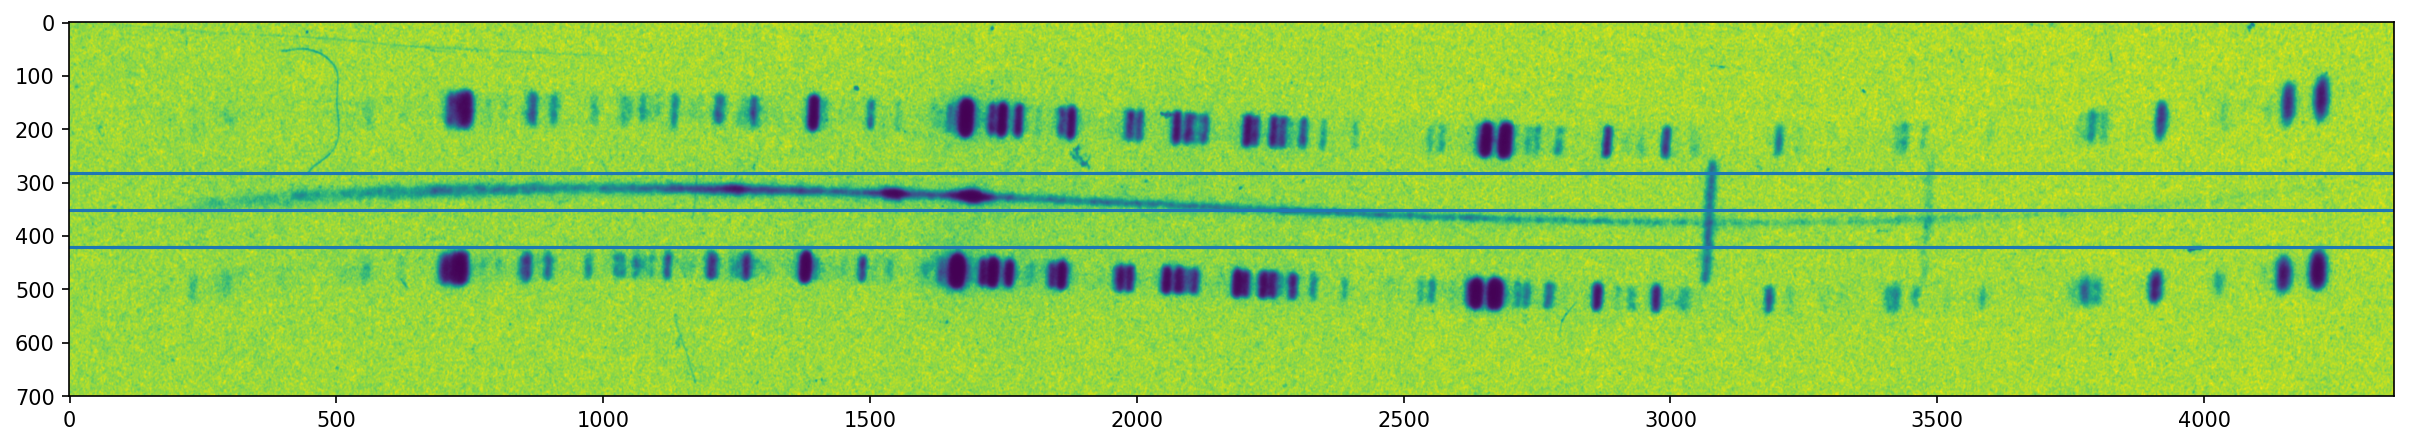

In [11]:
plt.figure(figsize=(20,5),dpi=150)
plt.imshow(image_NGC4151)
plt.axhline(center)
plt.axhline(upper)
plt.axhline(lower)

### PEAKS FINDING LAMPS

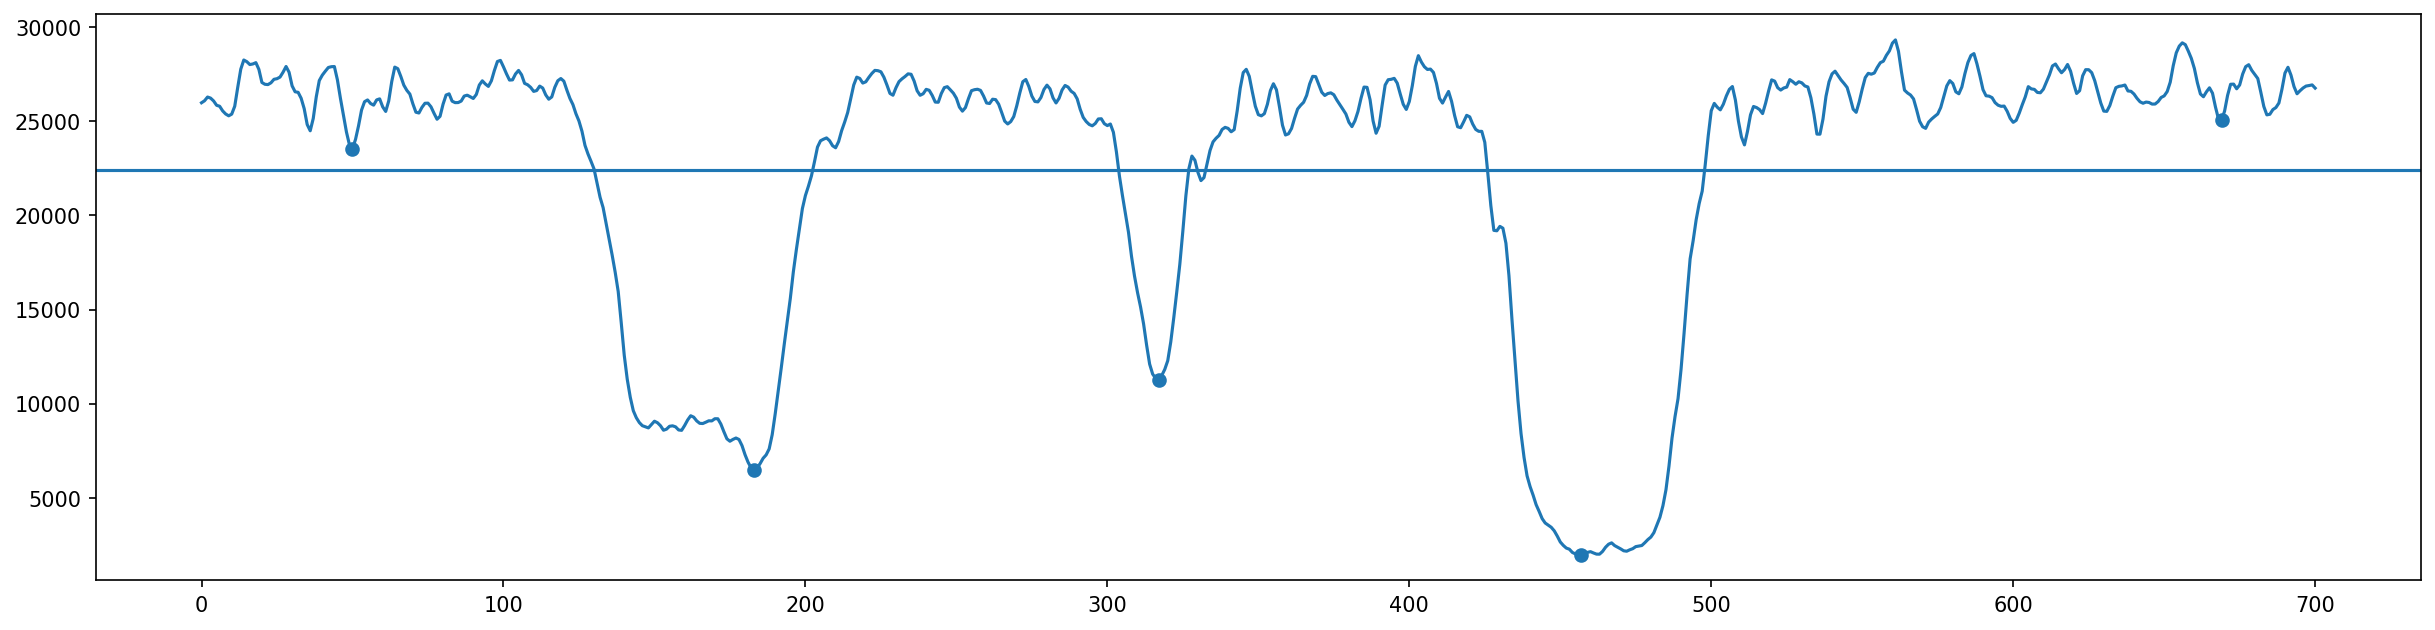

In [12]:
#TRIAL. HOW IT SHOULD LOOK LIKE
col_n = 711
peaks = signal.argrelextrema(image_NGC4151[:,col_n], np.less, order=35)[0] #индексы пиков 
plt.figure(figsize=(20,5),dpi=150)
plt.plot(image_NGC4151[:,col_n])
plt.axhline(image_NGC4151[:,col_n].mean())
plt.scatter(peaks,image_NGC4151[:,col_n][peaks])

In [13]:
peaks_right = []
peaks_left = []
order = len(image_NGC4151[0])/10 #десятая часть длинны для порядка поиска пиков, выбрано наобум
for i in range(len(image_NGC4151[0])):
    mean = image_NGC4151[:,i].mean()
    peaks_ids = signal.argrelextrema(image_NGC4151[:,i], np.less, order=10)[0]
    #print(peaks_ids)
    lowest_peaks = []
    for peak_id in peaks_ids:
        if image_NGC4151[:,i][peak_id] < mean:
            lowest_peaks.append(peak_id)
    #print(lowest_peaks)
    peaks_right.append(lowest_peaks[0])
    peaks_left.append(lowest_peaks[-1])
    

/home/adel/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, 'Rows')

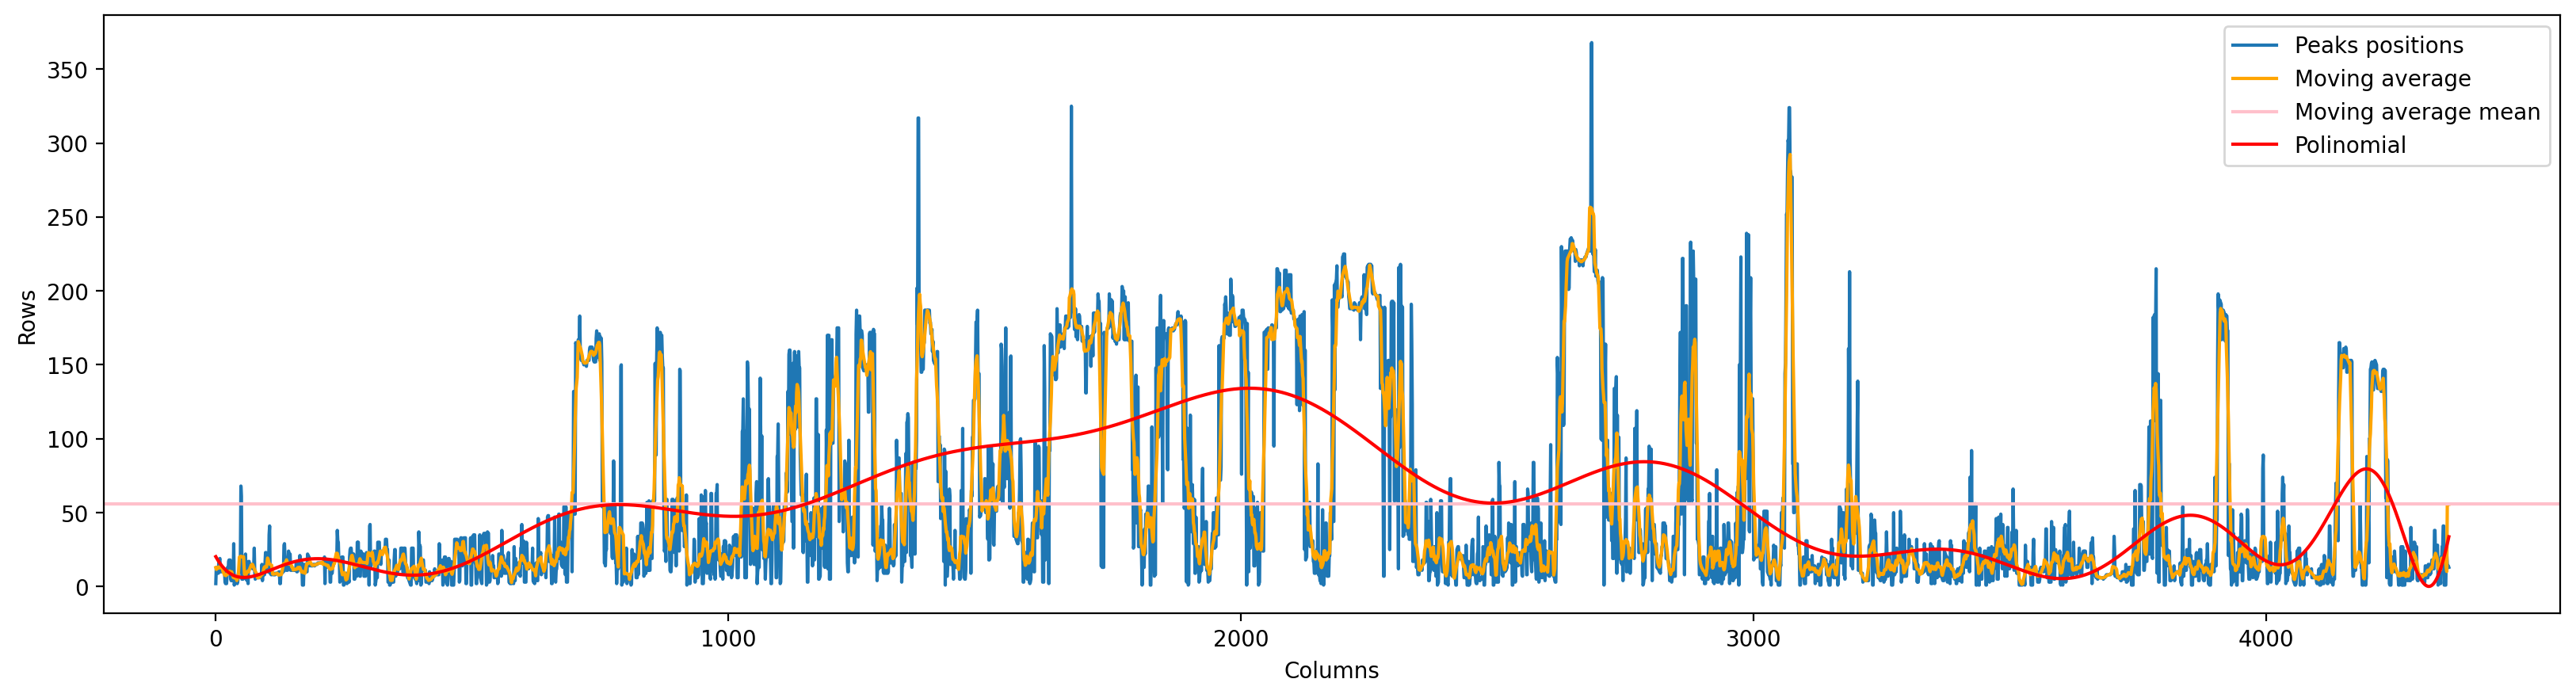

In [14]:
#PLOT RESULT OF PEAKS POSITION

fig, ax1 = plt.subplots(figsize=(20,5),dpi=200)
plt.plot(peaks_right, label="Peaks positions")

#MOVING AVARAGE

moving_av_right = (moving_average(10, peaks_right))
#because of method we may have additional 0 values. let's replace them by mean value
mean_moving_av_right = moving_av_right.mean()
for ind,val in enumerate(moving_av_right):
    if val == 0:
        moving_av_right[ind] = mean_moving_av_right
        
plt.plot(moving_av_right,c="orange",label="Moving average" )
plt.axhline(mean_moving_av_right,c="pink",label="Moving average mean" )


#POLINOMIAL

xp = np.arange(0,len(peaks_right))
z = np.polyfit(xp,peaks_right, 35)
polynomial = np.poly1d(z)
y_polynomial = polynomial(xp)
plt.plot(xp, y_polynomial, color="red", label=f"Polinomial")


plt.legend()
plt.xlabel("Columns")
plt.ylabel("Rows")

/home/adel/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, 'Rows')

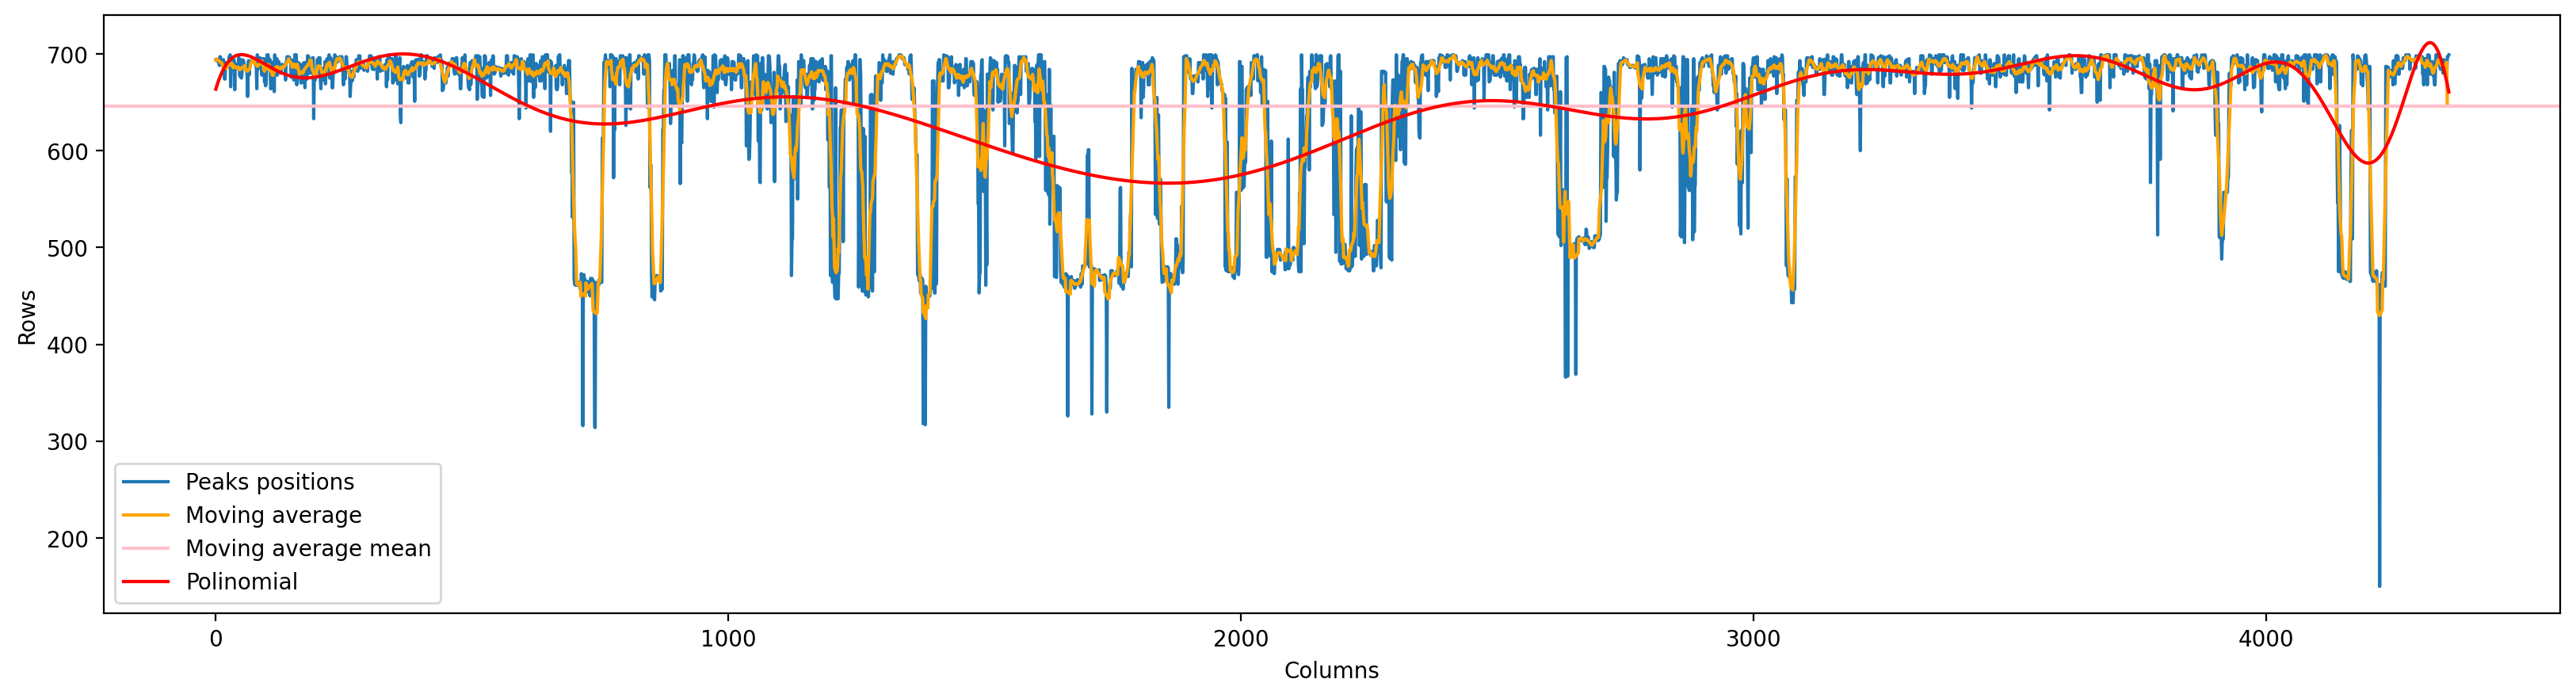

In [15]:
#PLOT RESULT OF PEAKS POSITION

fig, ax1 = plt.subplots(figsize=(20,5),dpi=200)
plt.plot(peaks_left, label="Peaks positions")


#MOVING AVARAGE

moving_av_left = moving_average(100, peaks_left)
#because of method we may have additional 0 values. let's replace them by mean value
mean_moving_av_left = moving_av_left.mean()
for ind,val in enumerate(moving_av_left):
    if val == 0:
        moving_av_left[ind] = mean_moving_av_left


plt.plot(moving_av_left,c="orange",label="Moving average")
plt.axhline(mean_moving_av_left,c="pink",label="Moving average mean" )


#POLINOMIAL

xp = np.arange(0,len(peaks_left))
z = np.polyfit(xp,peaks_left, 35)
polynomial = np.poly1d(z)
y_polynomial = polynomial(xp)
plt.plot(xp, y_polynomial, color="red", label=f"Polinomial")

plt.legend()
plt.xlabel("Columns")
plt.ylabel("Rows")

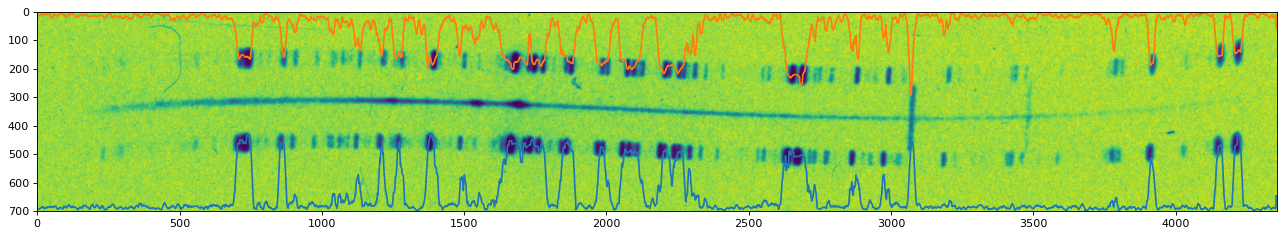

In [16]:
fig, ax1 = plt.subplots(figsize=(20,5),dpi=80)
plt.imshow(image_data_NGC4151)
plt.plot(moving_av_left)
plt.plot(moving_av_right)

### PEAKS FINDING SPECTRA

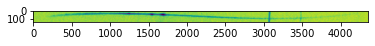

In [17]:
plt.imshow(image_NGC4151[lower:upper])

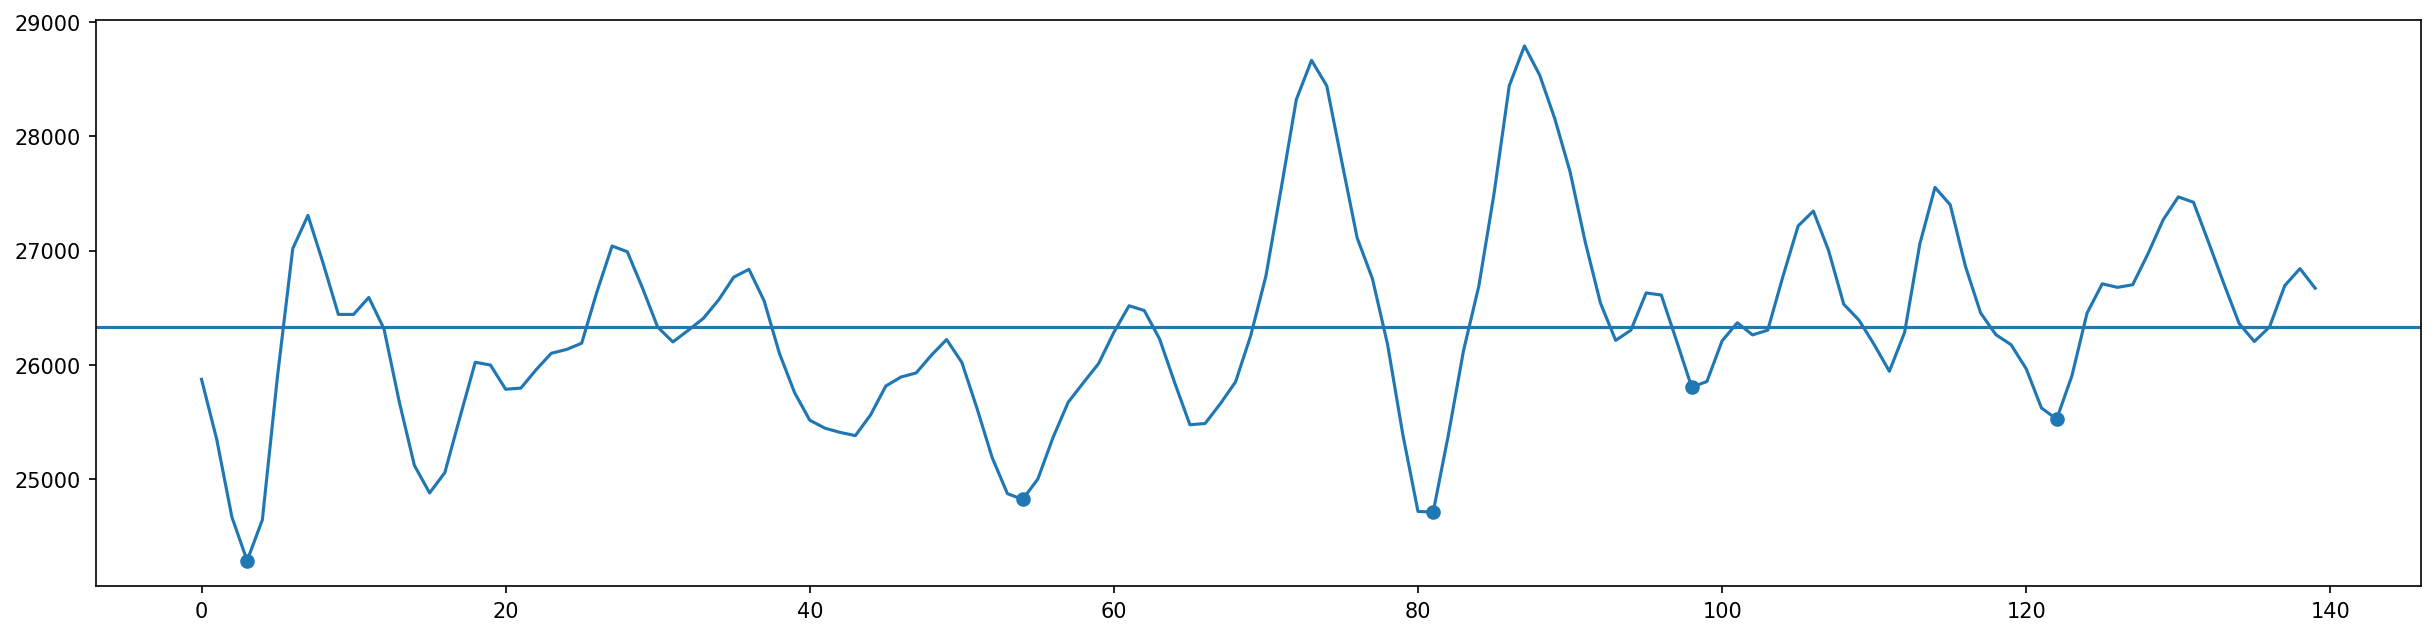

In [18]:
#TRIAL. HOW IT SHOULD LOOK LIKE
col_n = 10
peaks = signal.argrelextrema(image_NGC4151[lower:upper,col_n], np.less, order=14)[0] #индексы пиков 
plt.figure(figsize=(20,5),dpi=150)
plt.plot(image_NGC4151[lower:upper,col_n])
plt.axhline(image_NGC4151[lower:upper,col_n].mean())
plt.scatter(peaks,image_NGC4151[lower:upper,col_n][peaks])

In [19]:
peaks = []
order = rounding((upper-lower)/10) #десятая часть длинны для порядка поиска пиков, выбрано наобум
for i in range(len(image_NGC4151[0])):
    mean_row = (np.arange(0,upper-lower)).mean()
    peaks_ids = signal.argrelextrema(image_NGC4151[lower:upper,i], np.less, order=order)[0]
    delta = []
    #we should find delta because we cannot say 
    #"give me middle value" - there may be even number of values
    #so we have to use the closest to the center value (spectra is located approx in the center of image)
    for peak_id in peaks_ids:
        delta.append(abs(peak_id-mean_row))
    delta_min = np.min(delta)
    peaks.append(peaks_ids[delta.index(delta_min)])
    

In [20]:
peaks_spec=np.array(peaks)+lower #because we croped image in the spectra area

Text(0, 0.5, 'Rows')

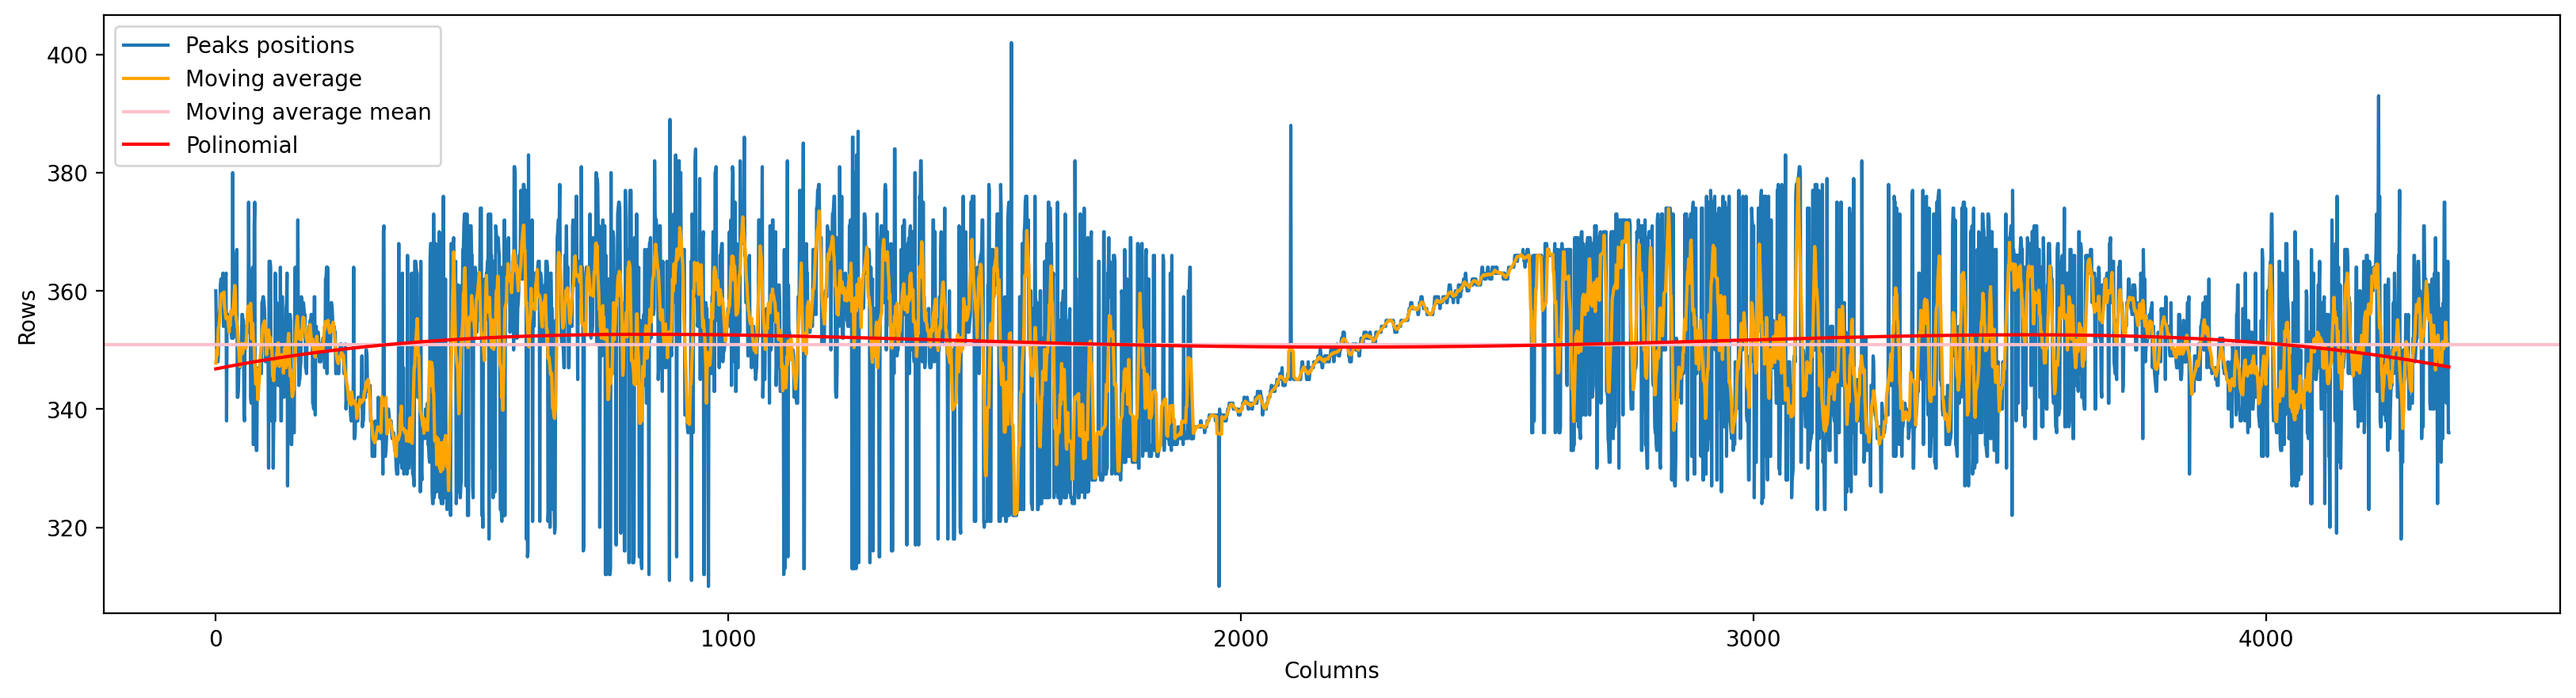

In [27]:
#PLOT RESULT OF PEAKS POSITION

fig, ax1 = plt.subplots(figsize=(20,5),dpi=200)
plt.plot(peaks_spec, label="Peaks positions")

#MOVING AVARAGE

moving_av_spec = moving_average(100, peaks_spec)
#because of method we may have additional 0 values. let's replace them by mean value
mean_moving_av_spec = moving_av_spec.mean()
for ind,val in enumerate(moving_av_spec):
    if val == 0:
        moving_av_spec[ind] = mean_moving_av_spec


plt.plot(moving_av_spec,c="orange",label="Moving average")
plt.axhline(mean_moving_av_spec,c="pink",label="Moving average mean" )

#POLINOMIAL

xp = np.arange(0,len(peaks_spec))
z = np.polyfit(xp,peaks_spec, 4)
polynomial = np.poly1d(z)
y_polynomial = polynomial(xp)
plt.plot(xp, y_polynomial, color="red", label=f"Polinomial")

plt.legend()
plt.xlabel("Columns")
plt.ylabel("Rows")

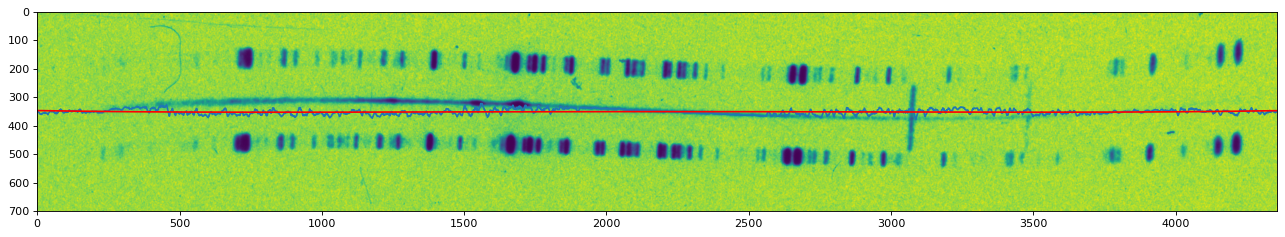

In [22]:
fig, ax1 = plt.subplots(figsize=(20,5),dpi=80)
plt.imshow(image_data_NGC4151)
plt.plot(moving_av_spec)
plt.plot(xp, y_polynomial, color="red", label=f"Polinomial")

In [23]:
dist = fits.open("ngc4151_dist.fits")[0].data

FileNotFoundError: [Errno 2] No such file or directory: 'ngc4151_dist.fits'

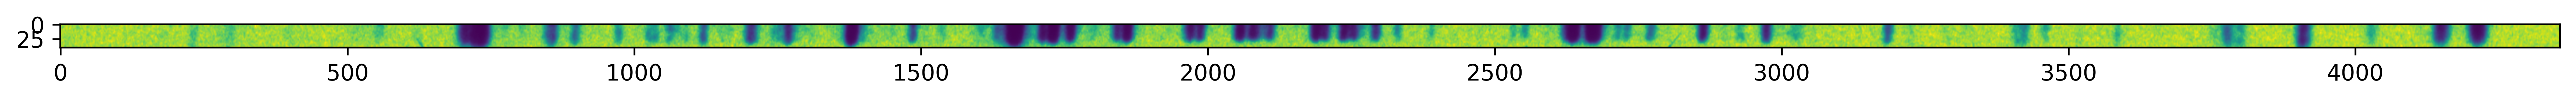

In [23]:
plt.subplots(figsize=(20,100),dpi=600)
plt.imshow(dist[480:520])
plt.imsave("dist.png",dist[480:520])

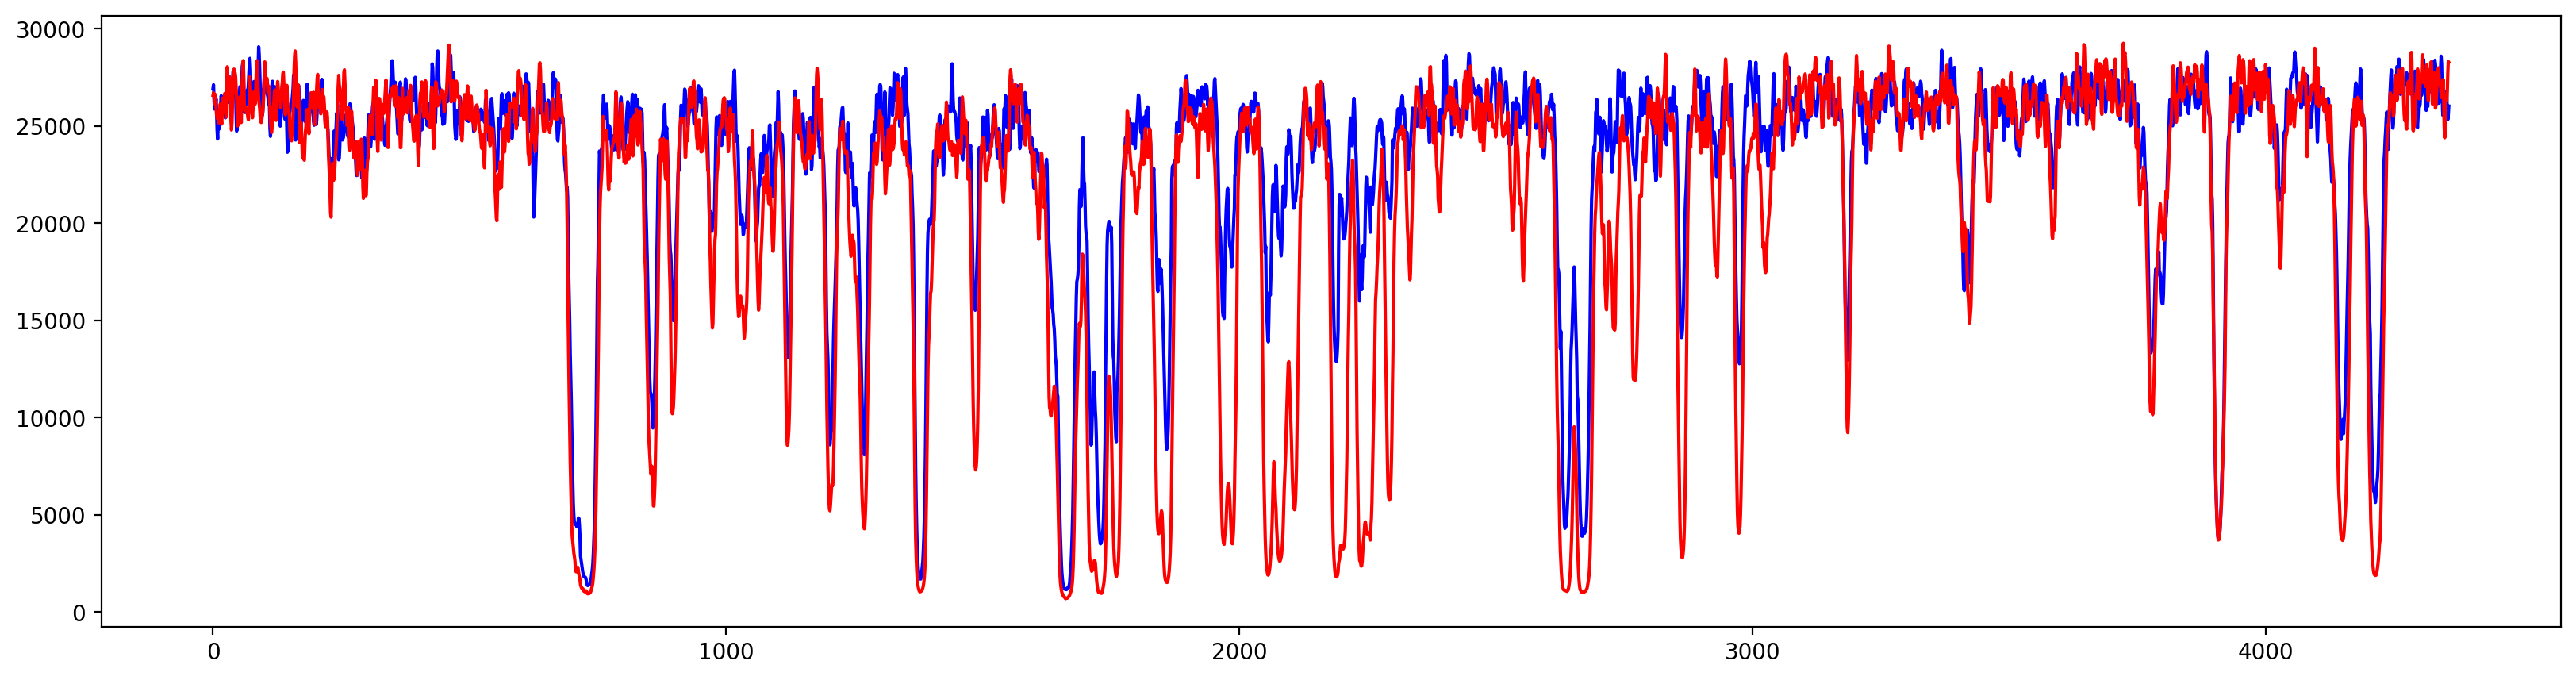

In [24]:
plt.subplots(figsize=(20,5),dpi=200)
plt.plot(dist[510,:],c="b")
plt.plot(dist[500,:],c="r")

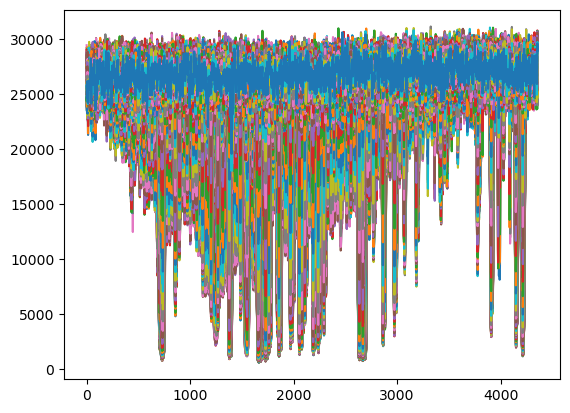

In [25]:
for i in range(len(image_NGC4151)):
    plt.plot(image_NGC4151[i,:])

## Normalization

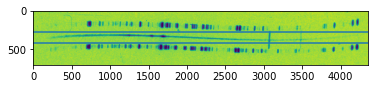

In [8]:
plt.imshow(image_data_NGC4151)
plt.axhline(270)
plt.axhline(420)

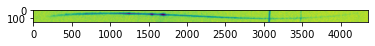

In [9]:
spectra_part = image_data_NGC4151[270:420]
plt.imshow(spectra_part)

In [123]:
def polynomial_alighn_normal(data,order):
    
    """
    function aligns the spectrum through finding min value in each column and approximate it with polynomial and mean for polinomial line
    
    data - whole image
    order - polinomial order to approximate spectra
    
    """
    
    fig, ax1 = plt.subplots(figsize=(8,5),dpi=100)
    ax1.imshow(data, cmap='gray')
#     plt.imsave('pic_lamp_20s.jpg', data_part)
    ax1.set_title("Initial part of spectra")
#     plt.savefig("initial_part.eps")
    
    #create massive of part of whole spectra with arrays of columns, not rows
    data_columns = []
    for i in range(0,len(data[0])):
        data_columns.append(list(data[:,i]))
    data_columns=list(data_columns)
    
    #create massive of whole spectra with arrays of columns, not rows
    data_collumns_entire_image = []
    for j in range(0,len(data[0])):
        data_collumns_entire_image.append(list(data[:,j]))
    data_collumns_entire_image=list(data_collumns_entire_image)

    #find min value in each column and then find indexes of the values - they will be Y-coordinate
    data_col_min = data.min(axis=0)
    index = []
    for i in range(0,len(data_col_min)):
            index.append(data_columns[i].index(data_col_min[i]))


    #find median value of neighboring indexes of min values in each column in some ranges to compairing in the next steps
    #we schould find mediam values for ranges not for whole image, because we have non-linear graph and it has curvature  
    median = []
    n = 0
    while n+100<len(index):
        k=n+100
        median.append([n,k,np.median(index[n:k])])
        n=k
    else:
        median.append([n,-1,np.median(index[n:])])

    #calculate mean delta between neighboring values
    delt=[]
    for i in range(1,len(index)):
        delt.append(abs(index[i]-index[i-1]))
    delt_mean = np.array(delt).sum()/len(delt)    

    #now we compair difference between median value indexes of minimum value in each column     
    for i in median:
        for j in range(i[0],i[1]):
            if abs(i[2]-index[j])>delt_mean:
                index[j] = i[2]

    fig, ax2 = plt.subplots(figsize=(8,5),dpi=100)
    ax2.plot(index)
    
    #plot polynomial
    xp = np.arange(0,len(index))
    z = np.polyfit(xp,index, order)
    polynomial = np.poly1d(z)
    y_polynomial = polynomial(xp)
    y_polynomial_int = []
    for i in range(len(y_polynomial)):
        y_polynomial_int.append(rounding(y_polynomial[i]))
        
    ax2.plot(index, color="steelblue", label="Srectra line") 
    ax2.plot(xp, y_polynomial, color="orange", label=f"Polinomial, order = {order}")
    ax2.set_title("Polinomial approximation of spectra")
    ax2.legend()
#     plt.savefig("polinomial_spectra.eps")
    
    #NORMALIZATION
    relation = np.zeros(data.shape)
    
    #matrix with relation for each pixel
    
    for row in range(len(data)):
        for col in range(len(data[row])):
            relation[row][col] = data[row][col]/data[y_polynomial_int[col]][col]
    #delta
    
    delta = np.zeros(data.shape)
    for row in range(len(relation)):
        for col in range(len(relation[row])):
        
            delta[row][col]=rounding(row*relation[row][col])
    #print(delta)        
    #roll
    new_pic = np.zeros(data.shape)
    for i in range(0,len(data)):
        #print(i)
        for j in range(0,len(data[i])):
            m  = int(delta[i][j])
            if m<len(data) and m >= 0:
                
                new_pic[m][j] = data[i][j] 
            elif m<0:
                m = len(data) + m
#                 print(m)
                new_pic[m][j] = data[i][j]
            else:
                m = int(m%(len(data)-1))
#                 print(m)
                new_pic[m][j] = data[i][j]
    
    aligned_image = new_pic
    
    fig, ax4 = plt.subplots(figsize=(8,5),dpi=100)
    ax4.imshow(aligned_image, cmap='gray')
    #ax4.grid()
    ax4.set_title("Aligned spectra 1st")
    #_________________________________________________________________________
    
    
    return aligned_image#delta, relation,


In [115]:
35%30

5

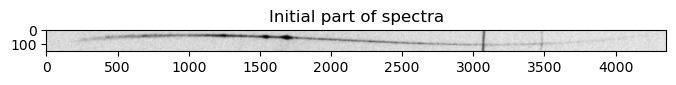

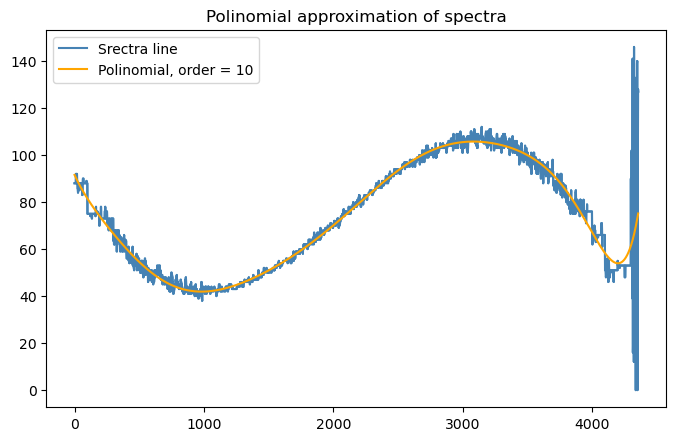

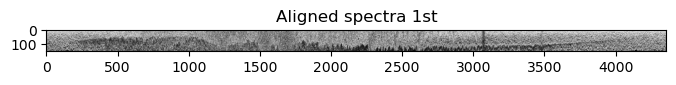

In [124]:
align = polynomial_alighn_normal(spectra_part,10)

In [125]:
align

array([[25164., 25292., 25635., ..., 26254., 26892., 27218.],
       [25674., 26006., 25993., ..., 25907., 26829., 27417.],
       [26066., 26763., 26555., ..., 28491., 28091., 27497.],
       ...,
       [    0., 27172.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ..., 28205.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [103]:
relation

array([[0.96399021, 0.96556461, 0.9444772 , ..., 0.93989187, 0.96911603,
        1.00246763],
       [0.98352742, 0.99282277, 0.95766711, ..., 0.92746931, 0.96684563,
        1.0097971 ],
       [0.99854428, 1.02172256, 0.97837299, ..., 0.9227795 , 0.96446717,
        1.0085448 ],
       ...,
       [0.962726  , 0.98369855, 0.98043621, ..., 1.00973761, 1.04151499,
        1.06732714],
       [0.96594393, 0.98518747, 0.97446764, ..., 1.01997638, 1.02872181,
        1.04298186],
       [0.97050261, 0.98289686, 0.96463048, ..., 1.02072823, 1.01232481,
        1.01274359]])

In [73]:
np.array(spectra_part[0])

TypeError: _dump() missing 1 required positional argument: 'file'

In [80]:
matrex = [[1,1,1,1,1,1],[2,2,2,2,2,2],[3,3,3,3,3,3],[4,4,4,4,4,4],[5,5,5,5,5,5]]

In [65]:

for row in range(0,len(spectra_part)):
    for col in range(0,len(spectra_part[row])):
        xp = np.arange(0,len(spectra_part.median))
        z = np.polyfit(xp,spectra_part[row], 3)
        polynomial = np.poly1d(z)
        y_polynomial = polynomial(xp)

KeyboardInterrupt: 

In [81]:
matrex

[[1, 1, 1, 1, 1, 1],
 [2, 2, 2, 2, 2, 2],
 [3, 3, 3, 3, 3, 3],
 [4, 4, 4, 4, 4, 4],
 [5, 5, 5, 5, 5, 5]]

In [27]:
np.array(matrex)[2]/np.array(matrex)

array([[3.  , 3.  , 3.  , 3.  , 3.  , 3.  ],
       [1.5 , 1.5 , 1.5 , 1.5 , 1.5 , 1.5 ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.75, 0.75, 0.75, 0.75, 0.75, 0.75],
       [0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.6 ]])

In [64]:
xp = np.arange(0,len(spectra_part))
z = np.polyfit(xp,spectra_part, 3)
polynomial = np.poly1d(z)
y_polynomial = polynomial(xp)

ValueError: Polynomial must be 1d only.

In [78]:
delta_matrix = np.array(y_polynomial)/np.array(spectra_part)

 ...]

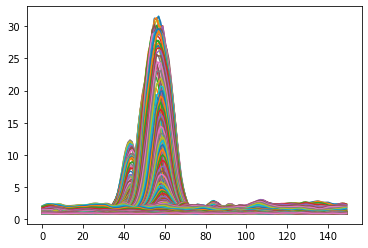

In [106]:
len(delta)

In [103]:
# new_pic = np.zeros(spectra_part.shape)
#_____________________________________
# xp = np.arange(0,len(spectra_part))
# z = np.polyfit(xp,spectra_part, 3)
# polynomial = np.poly1d(z)
# y_polynomial = polynomial(xp)
#_________________________________________
# delta_matrix = np.array(spectra_part)/np.array(spectra_part)
#________________________________________
for row in range(0,len(spectra_part)):
    for col in range(0,len(spectra_part[row])):
        spectra_part_mean = np.median(spectra_part[row])
        
    
    
delta_matrix = np.array(spectra_part_mean)/np.array(spectra_part)
#         if delta_matrix[row][col] == 1:
#             print([row][col])


In [109]:
delta_one = []
for row in range(0,len(delta_matrix)):
    for col in range(0,len(delta_matrix[row])):
        if delta_matrix[row][col] == 1.0:
            delta_one.append(delta_matrix[row][col])

In [111]:
len(delta_one)

191